# Duelling Deep Q-Networks on Crude Oil daily data

In this notebook a recurrent DQN model is trained on the crude oil daily dataset, enriched with the various tecnical indicators and the crude oil implied volatility index `OVX`.

The importance of **implied volatility** for market participants stems from the fact that it is one of the only data that is **forward-looking**. This is because market participants always trade contracts with an expiration date later in time. 

The goal of this notebook is to see how (if it is possible) a DQN trading agent can leverage this kind of data to learn a profitable trading strategy. 

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs

import torch

from gym_anytrading.agents.DDQN_agent import DDQNTradingAgent
from gym_anytrading.envs.future_env import FuturesEnv
from utils import MetricLogger

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [6]:
data_path = 'data/CL_daily_adj.csv'
window_size = 115
save_dir = Path("models/ddqn_cl_checkpoints") / datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
episodes = 400

In [9]:
cl_df = pd.read_csv(data_path, index_col=0, parse_dates=True)
cl_df

,open,high,low,close,MA,Smoothing Line,MA.1,Smoothing Line.1,Volume,Volume MA,ATR,RSI,RSI-based MA,open_ovx,high_ovx,low_ovx,close_ovx
Date,,,,,,,,,,,,,,,,,
2007-05-11,61.89,62.56,61.68,62.37,62.28530,62.40756,62.5848,62.57444,216920,228967.65,1.595914,46.550818,50.353979,26.41,26.41,26.41,26.41
2007-05-14,62.43,63.07,62.14,62.46,62.23140,62.34749,62.6012,62.58312,200433,227399.15,1.548348,46.999236,49.685978,27.23,27.23,27.23,27.23
2007-05-15,62.54,63.30,62.07,63.17,62.17525,62.28898,62.6632,62.60072,185334,225779.35,1.525609,50.525568,48.967185,27.89,27.89,27.89,27.89
2007-05-16,63.15,63.30,61.90,62.55,62.11345,62.23031,62.7004,62.62540,216160,225719.05,1.516637,47.550389,48.298946,27.07,27.07,27.07,27.07
2007-05-17,62.62,65.09,62.48,64.86,62.05870,62.17282,62.7612,62.66216,267955,228258.40,1.594734,57.574277,48.023056,24.86,24.86,24.86,24.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-07,119.10,120.36,117.14,119.41,88.46825,87.91657,106.4996,106.27560,313707,283652.20,4.639687,66.026135,59.179643,51.30,51.47,45.67,45.88
2022-06-08,119.79,123.18,119.30,122.11,88.75060,88.18925,106.8226,106.43304,306204,279474.90,4.585424,69.365176,60.446540,49.48,49.55,44.37,44.37
2022-06-09,122.43,122.72,120.79,121.51,89.02045,88.46562,107.1680,106.62916,254996,273089.65,4.395751,67.771155,61.375703,47.50,47.50,43.02,43.87


<AxesSubplot:xlabel='Date'>

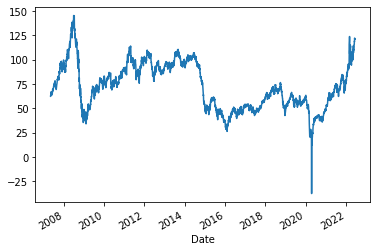

In [10]:
cl_df.close.plot()

## Preprocessing

The preprocessing phase consist in the following phases:

- addition of cyclical features for the time-related variables
- standardization of the data

In [11]:
def add_cyclical_features(df):
    df['date'] = pd.to_datetime(df.index.copy(), format='%Y-%m-%d')
    df['day_sin'] = df['date'].apply(lambda x: np.sin(x.day * (2. * np.pi / 30)))
    df['day_cos'] = df['date'].apply(lambda x: np.cos(x.day * (2. * np.pi / 30)))
    df['month_sin'] = df['date'].apply(lambda x: np.sin(x.month * (2. * np.pi / 12)))
    df['month_cos'] = df['date'].apply(lambda x: np.cos(x.month * (2. * np.pi / 12)))
    df = df.drop('date', axis=1)
    return df

In [12]:
cl_df = add_cyclical_features(cl_df)

## Train Loop

In [13]:
def train_loop(env, episodes: int, agent, logger):
    for episode in range(episodes):

        state = env.reset()

        while True:

            action = agent.act(state)

            next_state, reward, done, info = env.step(action)

            agent.cache(state, next_state, action, reward, done)

            q, loss = agent.learn()

            logger.log_step(reward, loss, q)

            state = next_state

            if done:
                print('info: ', info)
                break

        logger.log_episode()

        account_value = env.get_account_value()

        logger.record(
            episode=episode,
            epsilon=agent.exploration_rate,
            step=agent.curr_step,
            account_value=account_value)

## Training

Only 80% of the total data is used during the training phase. That's because we want to avoid the model simply memorizing the dataset (overfitting) and obtaining a model that is generalized well in all market situations.

The DQN model is a reccurrent neural network with 3 layer and with an hidden size of 64, the neural network will be given as input the hourly data of the previous week.

In [14]:
training_portion = 0.8
train_cl_df = cl_df[0:int(np.floor(len(cl_df) * training_portion))]
env = FuturesEnv(df=train_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(train_cl_df)))
agent = DDQNTradingAgent(
    env.observation_space.shape[1],
    env.action_space.n,
    save_dir)
logger = MetricLogger(save_dir)

In [ ]:
train_loop(env, episodes, agent, logger)

## Testing the model

Now that the model has been trained, let's test its performance on the testing data (out of sample data).

In [ ]:
def model_testing(env, agent):

    i = 0

    state = env.reset()

    while True:

        action = agent.act(state, eval_mode=True)

        next_state, reward, done, info = env.step(action)

        state = next_state

        if done:
            print('info: ', info)
            break

        print(f'step: {i}, reward: {reward}, account_value: {env.get_account_value()}, action: {action}, position: {info["position"]}')

        i += 1

In [ ]:
test_cl_df = cl_df[int(np.floor(len(cl_df) * training_portion)):]
env = FuturesEnv(df=test_cl_df,
                 window_size=window_size,
                 frame_bound=(window_size, len(test_cl_df)))

In [ ]:
model_testing(env, agent)

In [ ]:
plt.cla()
env.render_all()
plt.title('Testing')

## Testing period Statistics

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=test_cl_df.index[22:])
net_worth.index = pd.to_datetime(net_worth.index)

returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns, match_dates=True)